* morning (6 am - 12 pm, calculated daily)
* afternoon (12 pm - 6 pm, calculated daily)
* evening (6 pm - 12 am, calculated daily)
* night (12 am - 6 am, calculated daily)

# Causal discovery and inference by circadian rhythm

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   # nice heatmaps; pip install seaborn if missing
from pathlib import Path

circadian_metrics = pd.read_csv("circadian_metrics.csv")
# drop invalid data
circadian_metrics = circadian_metrics[circadian_metrics["pid"] != "INS-W_322"]
circadian_metrics.head(5)

,pid,BDI2_PRE,BDI2_POST,BDI_change,IV_morning,CV_morning,IV_afternoon,CV_afternoon,IV_evening,CV_evening,...,STAI_POST,MAAS_15items_POST,BriefCope_adaptive_POST,BriefCope_maladaptive_POST,GQ_POST,FSPWB_POST,EDS_POST,CEDH_POST,BYAACQ_POST,PSS_14items_POST
0,INS-W_1000,12.0,23.0,11.0,1.782346,0.633433,2.497112,1.382155,NaN,NaN,...,57.0,3.066667,1.5625,1.333333,30.0,43.0,24.0,16.0,NaN,30.0
1,INS-W_1002,22.0,14.0,-8.0,NaN,NaN,2.023177,0.253431,2.427625,0.530937,...,49.0,4.133333,0.5000,0.416667,35.0,38.0,0.0,0.0,NaN,19.0
2,INS-W_1003,12.0,9.0,-3.0,1.717540,0.447944,2.420000,3.162278,1.481064,1.459806,...,46.0,4.200000,1.1250,1.000000,35.0,44.0,3.0,6.0,0.0,27.0
3,INS-W_1004,8.0,0.0,-8.0,1.481218,0.420371,NaN,NaN,1.726707,0.556608,...,39.0,4.800000,0.5000,0.000000,36.0,48.0,0.0,0.0,0.0,15.0
4,INS-W_1005,24.0,11.0,-13.0,1.785522,0.695233,2.250000,1.414214,2.038026,0.516201,...,48.0,2.266667,1.3125,1.000000,33.0,47.0,0.0,6.0,NaN,32.0


In [92]:
circadian_metrics[["BDI_change", "IV_morning", "CV_morning", "IV_night", "CV_night"]].isna().sum()

BDI_change     0
IV_morning    16
CV_morning    14
IV_night      16
CV_night      14
dtype: int64

In [93]:
circadian_metrics[["BDI_change", "IV_afternoon", "CV_afternoon", "IV_evening", "CV_evening"]].isna().sum()

BDI_change        0
IV_afternoon    224
CV_afternoon    204
IV_evening      103
CV_evening       81
dtype: int64

## Let's just try estimating

### 1 | Transparent linear model + bootstrap CIs

In [98]:
import pandas as pd, numpy as np
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
import statsmodels.api as sm
from sklearn.utils import resample

df   = circadian_metrics              # 43 × (many)
covs = ["BDI2_PRE"]                                       # minimal confounder set
# Xraw = df[["IV_morning","CV_morning","IV_night","CV_night"] + covs]
Xraw = df[["CV_morning","CV_night"] + covs]
# Xraw = df[["IV_morning","IV_night"] + covs]


Y    = df["BDI_change"]

# impute missing CV_ afternoon / evening etc. (if still present)
Ximp = IterativeImputer(random_state=0).fit_transform(Xraw)
X    = sm.add_constant(Ximp)

# ---------- bootstrap ----------
coefs = []
for _ in range(5000):
    idx   = resample(range(len(df)), replace=True)
    mod   = sm.OLS(Y.iloc[idx], X[idx]).fit()
    coefs.append(mod.params)

boot = pd.DataFrame(coefs)
est  = boot.mean()
ci95 = boot.quantile([.025,.975])

print("Bootstrap estimates and 95% CI")
print(pd.concat([est, ci95.transpose()], axis=1)
        .rename(columns={0.025:"low",0.975:"high"}))


Bootstrap estimates and 95% CI
            0.0       low      high
const  1.501864 -0.491063  3.586671
x1     1.396909 -3.275530  6.320180
x2     3.566186  0.575975  6.640654
x3    -0.221225 -0.293242 -0.146652


### 2 | Permutation test (non-parametric)

In [99]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# fit on real data
lr = LinearRegression().fit(Ximp, Y)
r2_real = r2_score(Y, lr.predict(Ximp))
print(r2_real)

# permutation null
r2_null = []
for _ in range(10_000):
    y_perm = np.random.permutation(Y)
    r2_null.append(r2_score(y_perm, lr.fit(Ximp, y_perm).predict(Ximp)))

pval = (np.sum(np.array(r2_null) >= r2_real) + 1) / (len(r2_null) + 1)
print(f"Permutation p-value (global model R²): {pval:.4f}")


0.07897333484814129
Permutation p-value (global model R²): 0.0001


In [100]:
import pandas as pd, numpy as np
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.metrics import r2_score
import statsmodels.api as sm

# ------------------------------------------------------------------
# 1. load data -----------------------------------------------------
cm = pd.read_csv("circadian_metrics.csv")

# predictors = ["IV_morning", "CV_morning", "IV_night", "CV_night"]
predictors = ["CV_morning", "CV_night"]

covariates = ["BDI2_PRE"]                    # keep baseline as confounder
X_raw = cm[predictors + covariates]
y      = cm["BDI_change"]

# ------------------------------------------------------------------
# 2. impute & scale predictors ------------------------------------
imp     = IterativeImputer(max_iter=10, random_state=0)
X_imp   = imp.fit_transform(X_raw)
scaler  = StandardScaler()
X_std   = scaler.fit_transform(X_imp)

X       = sm.add_constant(X_std)             # add intercept for statsmodels
varnames = ["const"] + predictors + covariates

# ------------------------------------------------------------------
# 3. OLS with p-values & F-test -----------------------------------
ols = sm.OLS(y, X, hasconst=True)
res = ols.fit()
print(res.summary(xname=varnames))

# ------------------------------------------------------------------
# 4. permutation R² ----------------------------------------------
n_perm = 10_000
r2_obs = r2_score(y, res.fittedvalues)

r2_null = np.empty(n_perm)
for i in range(n_perm):
    y_perm = np.random.permutation(y)
    r2_null[i] = r2_score(y_perm, sm.OLS(y_perm, X).fit().fittedvalues)

p_perm = (np.sum(r2_null >= r2_obs) + 1) / (n_perm + 1)
print(f"\nObserved R² = {r2_obs:.3f}")
print(f"Permutation p-value (R²) = {p_perm:.4g}")


                            OLS Regression Results                            
Dep. Variable:             BDI_change   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     14.43
Date:                Mon, 12 May 2025   Prob (F-statistic):           4.90e-09
Time:                        04:02:40   Log-Likelihood:                -1707.4
No. Observations:                 513   AIC:                             3423.
Df Residuals:                     509   BIC:                             3440.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3743      0.299      1.251      0.2

### 3 | Bayesian regression (credibility instead of p-values)

In [ ]:
import pymc as pm
with pm.Model() as m:
    β0 = pm.Normal("Intercept", 0, 10)
    β  = pm.Normal("β", 0, 2, shape=Ximp.shape[1]-1)
    σ  = pm.HalfNormal("σ", 5)
    μ  = β0 + pm.math.dot(Ximp[:,1:], β)
    pm.Normal("y", μ, σ, observed=Y.values)
    trace = pm.sample(4000, chains=4, target_accept=.9)

pm.draw_posterior(trace, var_names=["β"])


# Try CV

In [ ]:
# ---------------------------------------------------------------
# 1.  load circadian_metrics  (index = pid) ----------------------
# ---------------------------------------------------------------
cm = circadian_metrics

# columns of interest
cv_cols = ["BDI2_PRE", "CV_morning", "CV_afternoon","CV_evening", "CV_night"]
# cv_cols = [ "CV_morning", "CV_afternoon","CV_evening", "CV_night"]
y_col  = "BDI_change"

# quick sanity-check: display NaN counts
print("NaN counts:\n", cm[cv_cols + [y_col]].isna().sum())

# ---------------------------------------------------------------
# 2.  impute missing CV_evening / CV_afternoon ------------------
# ---------------------------------------------------------------
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
import numpy as np

X_raw = cm[cv_cols]                # predictors
y_raw = cm[y_col].astype(float)    # continuous outcome

# MICE imputation for X
imp = IterativeImputer(max_iter=10, random_state=0)
X_imp = imp.fit_transform(X_raw)

# standardise X (optional but helps Fisher-Z test)
scaler = StandardScaler()
X_std = scaler.fit_transform(X_imp)

# ---------------------------------------------------------------
# 3.  build data matrix  [ X_std  |  y ] -------------------------
# ---------------------------------------------------------------
data = np.column_stack([X_std, y_raw.values])
print("Matrix shape:", data.shape)       # should be n_participants × 5

# ---------------------------------------------------------------
# 4.  run PC -----------------------------------------------------
# ---------------------------------------------------------------
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.GraphUtils import GraphUtils
from io import BytesIO
import matplotlib.pyplot as plt

# variable names in the same order as columns in 'data'
var_names = cv_cols + [y_col]
for i, var in enumerate(var_names):
    print(f"X{i+1} = {var}")

cg = pc(data, alpha=0.05, var_names=var_names)     # Fisher's Z by default
# If you prefer kernel-based independence test:
# cg = pc(data, alpha=0.05, indep_test='kci', var_names=var_names)

# ---------------------------------------------------------------
# 5.  inspect edges touching the outcome ------------------------
# ---------------------------------------------------------------
print("Edges")
for e in cg.G.get_graph_edges():
    n1, n2 = e.get_node1().get_name(), e.get_node2().get_name()
    print(e.get_endpoint1(), n1, "<->", n2, e.get_endpoint2())

NaN counts:
 CV_morning       14
CV_afternoon    204
CV_evening       81
CV_night         14
BDI_change        0
dtype: int64
Matrix shape: (512, 5)
X1 = CV_morning
X2 = CV_afternoon
X3 = CV_evening
X4 = CV_night
X5 = BDI_change


Depth=1, working on node 4: 100%|██████████| 5/5 [00:00<00:00, 422.51it/s] 

Edges
TAIL X2 <-> X1 ARROW
TAIL X3 <-> X1 ARROW
TAIL X2 <-> X4 ARROW
TAIL X3 <-> X4 ARROW


In [113]:
# ---------------------------------------------------------------
#  Run GES with BIC (treats dep_bin as continuous 0/1)
# ---------------------------------------------------------------
from causallearn.search.ScoreBased.GES import ges

ges_res = ges(data, score_func="local_score_BIC", maxP=5)
G = ges_res["G"]

print("GES edges: ")
for e in G.get_graph_edges():
    n1 = e.get_node1().get_name()  # Access node name directly
    n2 = e.get_node2().get_name()  # Access node name directly
    print(e.get_endpoint1(), n1, "<->", n2, e.get_endpoint2())

GES edges: 
TAIL X2 <-> X1 ARROW
TAIL X3 <-> X1 ARROW
TAIL X1 <-> X4 TAIL
TAIL X2 <-> X4 ARROW
TAIL X3 <-> X4 ARROW


# Causal Discovery for all subjects

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   # nice heatmaps; pip install seaborn if missing
from pathlib import Path

DATA = Path("data/processed/globem_causal_input.csv")
globem_df = pd.read_csv(DATA, index_col="pid")
print("shape:", globem_df.shape)
globem_df.head()

shape: (576, 26)


,BFI10_conscientiousness_PRE,BFI10_extroversion_PRE,BFI10_neuroticism_PRE,BRS_PRE,PSS_10items_PRE,f_screen:phone_screen_rapids_sumdurationunlock_locmap_living_norm:weekend__mean,f_slp:fitbit_sleep_summary_rapids_avgefficiencymain_norm:weekend__mean,f_slp:fitbit_sleep_intraday_rapids_ratiocountasleepunifiedwithinmain_norm:afternoon__mean,f_screen:phone_screen_rapids_firstuseafter00unlock_locmap_exercise_norm:weekend__mean,f_blue:phone_bluetooth_doryab_countscansmostfrequentdeviceacrosssegmentsall_norm:weekday__mean,...,f_slp:fitbit_sleep_summary_rapids_countepisodemain_norm:weekday__mean,f_slp:fitbit_sleep_summary_rapids_countepisodemain_norm:weekend__mean,f_steps:fitbit_steps_intraday_rapids_avgdurationsedentarybout_norm:night__mean,f_wifi:phone_wifi_connected_rapids_countscansmostuniquedevice_norm:weekend__mean,f_steps:fitbit_steps_summary_rapids_stdsumsteps_norm:weekend__mean,f_wifi:phone_wifi_connected_rapids_countscans_norm:weekend__mean,f_steps:fitbit_steps_intraday_rapids_maxdurationactivebout_norm:14dhist__mean,f_steps:fitbit_steps_summary_rapids_minsumsteps_norm:weekend__mean,f_steps:fitbit_steps_summary_rapids_minsumsteps_norm:14dhist__mean,dep_bin
pid,,,,,,,,,,,,,,,,,,,,,
INS-W_003,5.0,3.0,10.0,1.000000,33.0,-0.149397,-3.861004e-02,-0.093646,-0.168025,0.156250,...,0.000000,-0.168067,0.155106,NaN,-0.144165,NaN,-0.148903,0.014889,0.002458,1.0
INS-W_004,9.0,7.0,8.0,2.666667,22.0,0.009042,4.848485e-02,NaN,0.222471,0.145455,...,-0.363636,-0.181818,0.122615,NaN,0.098711,NaN,0.122222,0.161928,0.075854,1.0
INS-W_005,8.0,7.0,8.0,3.500000,14.0,0.067405,4.545455e-02,-0.370370,-0.203033,0.164119,...,-0.177305,0.000000,0.163089,NaN,0.023110,NaN,0.125196,0.076843,0.189277,0.0
INS-W_006,7.0,8.0,5.0,4.000000,13.0,0.103422,-7.168459e-02,0.000000,0.005053,0.226226,...,-0.259740,-0.222222,0.153489,NaN,-0.018187,NaN,0.001139,0.091583,0.217117,0.0
INS-W_008,7.0,6.0,7.0,3.666667,23.0,-0.169856,-5.551115e-18,0.029940,-0.175969,0.224377,...,0.136364,-0.181818,-0.108195,NaN,-0.066104,NaN,-0.071739,0.232422,0.039808,1.0


# Make depression an end node

In [72]:
# ---------------------------------------------------------------
#  Impute + scale predictors exactly as before
# ---------------------------------------------------------------
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
import pandas as pd, numpy as np

df = pd.read_csv("data/processed/globem_causal_input.csv", index_col="pid")
y  = df["dep_bin"].astype(int).to_numpy()          # binary 0/1
X_df = df.drop(columns=["dep_bin"])
# X_df = df.drop(columns= ["dep_bin", "BFI10_conscientiousness_PRE", "BFI10_extroversion_PRE", "BFI10_neuroticism_PRE", "BRS_PRE", "PSS_10items_PRE"])

# MICE imputation + scaling for predictors
X_imp = IterativeImputer(max_iter=10, random_state=0).fit_transform(X_df)
X_std = StandardScaler().fit_transform(X_imp)

# ---------------------------------------------------------------
#  Stack outcome column at the END of the matrix
# ---------------------------------------------------------------
data = np.column_stack([X_std, y])
var_names = X_df.columns.tolist() + ["dep_bin"]
print("matrix:", data.shape)

# ---------------------------------------------------------------
#  Run GES with BIC (treats dep_bin as continuous 0/1)
# ---------------------------------------------------------------
from causallearn.search.ScoreBased.GES import ges

ges_res = ges(data, score_func="local_score_BIC", maxP=5)
G = ges_res["G"]

matrix: (576, 26)


Edges touching dep_bin:


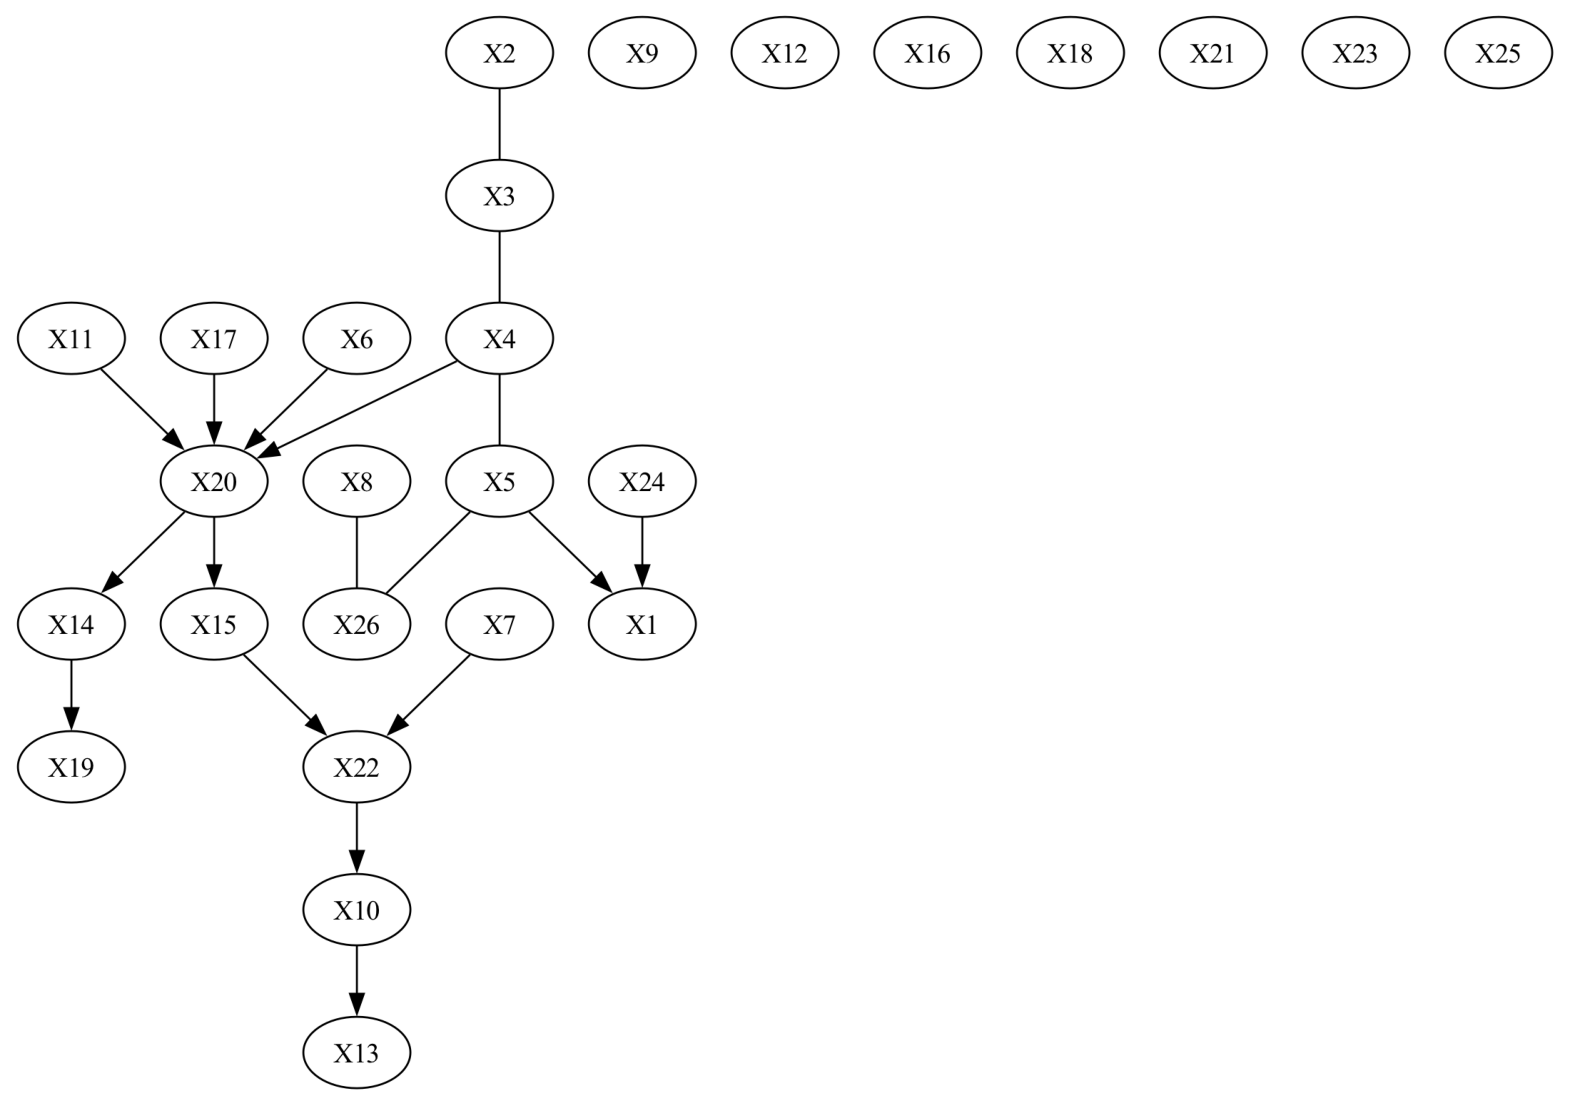

In [73]:
import pydot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from io import BytesIO
from causallearn.utils.GraphUtils import GraphUtils

# Print edges touching dep_bin
print("Edges touching dep_bin:")
for e in G.get_graph_edges():
    n1 = e.get_node1().get_name()  # Access node name directly
    n2 = e.get_node2().get_name()  # Access node name directly
    if "X46" in (n1, n2):
        print(e.get_endpoint1(), n1, "<->", n2, e.get_endpoint2())

# Convert the causal graph to a pydot graph and display it
pydot_graph = GraphUtils.to_pydot(G)

# Create PNG image data from the pydot graph
png_bytes = pydot_graph.create_png(f="png")
if png_bytes is None:
    raise RuntimeError("Failed to create image via Graphviz. "
                       "Please ensure that Graphviz is installed and in your system PATH.")

# Display the image using Matplotlib
image_stream = BytesIO(png_bytes)
img = mpimg.imread(image_stream, format='png')
plt.figure(figsize=(20, 20))
plt.imshow(img)
plt.axis('off')  # Hide axes for a cleaner look
plt.show()

In [74]:
for i, var_name in enumerate(var_names):
    print(i+1, var_name)

1 BFI10_conscientiousness_PRE
2 BFI10_extroversion_PRE
3 BFI10_neuroticism_PRE
4 BRS_PRE
5 PSS_10items_PRE
6 f_screen:phone_screen_rapids_sumdurationunlock_locmap_living_norm:weekend__mean
7 f_slp:fitbit_sleep_summary_rapids_avgefficiencymain_norm:weekend__mean
8 f_slp:fitbit_sleep_intraday_rapids_ratiocountasleepunifiedwithinmain_norm:afternoon__mean
9 f_screen:phone_screen_rapids_firstuseafter00unlock_locmap_exercise_norm:weekend__mean
10 f_blue:phone_bluetooth_doryab_countscansmostfrequentdeviceacrosssegmentsall_norm:weekday__mean
11 f_call:phone_calls_rapids_incoming_timelastcall_norm:evening__mean
12 f_call:phone_calls_rapids_missed_count_norm:7dhist__mean
13 f_blue:phone_bluetooth_doryab_uniquedevicesown_norm:7dhist__mean
14 f_loc:phone_locations_locmap_duration_in_locmap_study_norm:night__std
15 f_loc:phone_locations_doryab_timeattop1location_norm:weekend__mean
16 f_slp:fitbit_sleep_summary_rapids_firstwaketimemain_norm:weekend__mean
17 f_slp:fitbit_sleep_summary_rapids_countepi

## PC algorithm

This did not produce reasonable results. PC and FCI works better with continuous values.

Matrix shape: (576, 26)


Depth=5, working on node 25: 100%|██████████| 26/26 [00:00<00:00, 1079.03it/s]


Edges touching dep_bin:
TAIL X5 <-> X26 TAIL
TAIL X8 <-> X26 TAIL
TAIL X26 <-> X10 ARROW
TAIL X26 <-> X11 ARROW


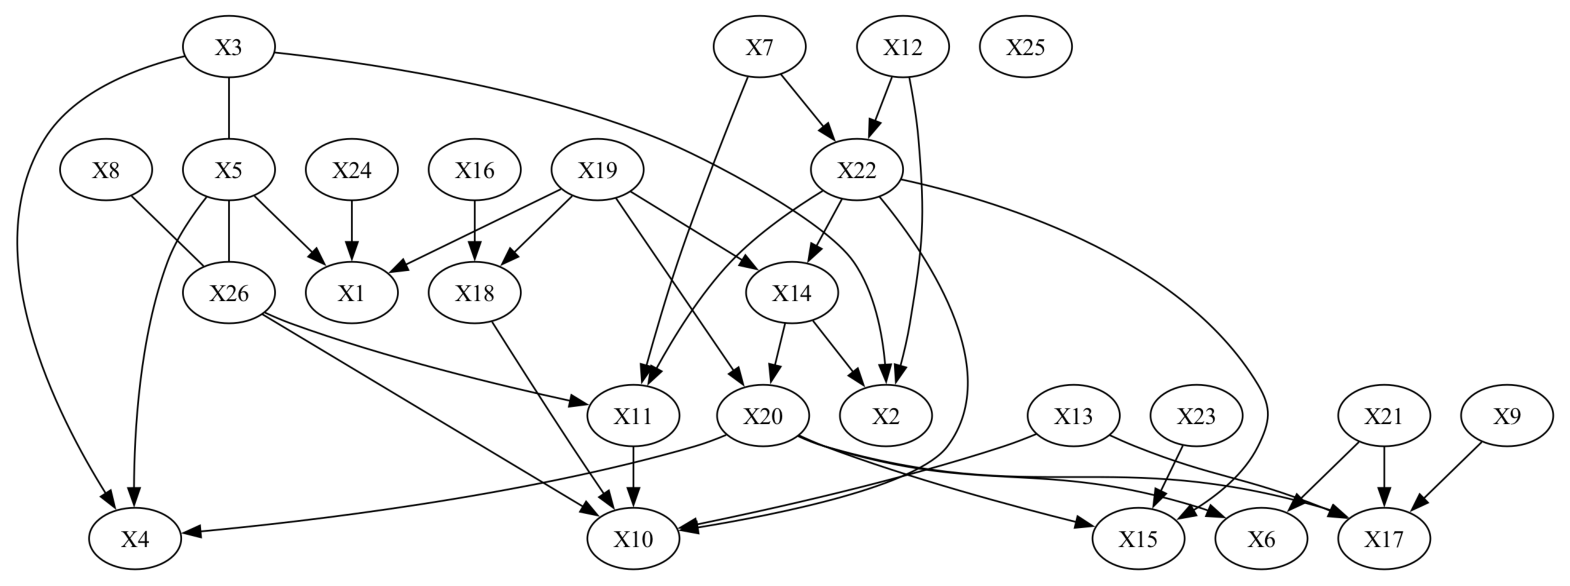

In [76]:
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.GraphUtils import GraphUtils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO

# Load your dataset
df = pd.read_csv("data/processed/globem_causal_input.csv", index_col="pid")
y = df["dep_bin"].astype(int).to_numpy()  # Binary outcome variable
X_df = df.drop(columns=["dep_bin"])
# X_df = df.drop(columns= ["dep_bin", "BFI10_conscientiousness_PRE", "BFI10_extroversion_PRE", "BFI10_neuroticism_PRE", "BRS_PRE", "PSS_10items_PRE"])

# Preprocess the data (Imputation + Scaling)
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler

# MICE imputation + scaling for predictors
X_imp = IterativeImputer(max_iter=10, random_state=0).fit_transform(X_df)
X_std = StandardScaler().fit_transform(X_imp)

# Stack outcome column at the end of the matrix
data = np.column_stack([X_std, y])
print("Matrix shape:", data.shape)

# Run PC algorithm
cg = pc(data, alpha=0.05)  # Default PC with Fisher's Z test and alpha=0.05

# Run PC with a kernel-based test (this might give better results for non-linear relationships)
# cg = pc(data, alpha=0.05, indep_test="kci", kernelZ="Polynomial", approx=False)

# Print edges touching dep_bin (or any other variable you're interested in)
print("Edges touching dep_bin:")
for e in cg.G.get_graph_edges():
    n1 = e.get_node1().get_name()
    n2 = e.get_node2().get_name()
    if "X26" in (n1, n2):
        print(e.get_endpoint1(), n1, "<->", n2, e.get_endpoint2())

# Visualize the causal graph using pydot
pydot_graph = GraphUtils.to_pydot(cg.G)

# Create PNG image data from the pydot graph
png_bytes = pydot_graph.create_png(f="png")
if png_bytes is None:
    raise RuntimeError("Failed to create image via Graphviz. "
                       "Please ensure that Graphviz is installed and in your system PATH.")

# Display the image using Matplotlib
image_stream = BytesIO(png_bytes)
img = plt.imread(image_stream, format='png')  # Using plt.imread for compatibility
plt.figure(figsize=(20, 20))
plt.imshow(img)
plt.axis('off')  # Hide axes for a cleaner look
plt.show()


/Users/kwang/.local/share/mamba/envs/causal/lib/python3.11/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Matrix shape: (576, 46)


Depth=8, working on node 45: 100%|██████████| 46/46 [00:00<00:00, 1156.88it/s]


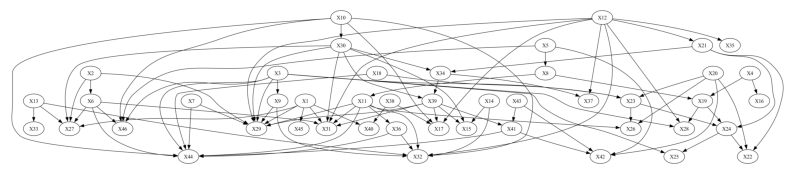

In [63]:
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.GraphUtils import GraphUtils
from causallearn.graph.GraphClass import CausalGraph
from causallearn.graph.Edge import Edge
from causallearn.graph.Endpoint import Endpoint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO

# Load your dataset
df = pd.read_csv("data/processed/globem_causal_input.csv", index_col="pid")
y = df["dep_bin"].astype(int).to_numpy()  # Binary outcome variable
X_df = df.drop(columns=["dep_bin", "BFI10_conscientiousness_PRE", "BFI10_extroversion_PRE", "BFI10_neuroticism_PRE", "BRS_PRE", "PSS_10items_PRE"])

# Preprocess the data (Imputation + Scaling)
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler

# MICE imputation + scaling for predictors
X_imp = IterativeImputer(max_iter=10, random_state=0).fit_transform(X_df)
X_std = StandardScaler().fit_transform(X_imp)

# Stack outcome column at the end of the matrix
data = np.column_stack([X_std, y])
print("Matrix shape:", data.shape)

# Run PC algorithm
cg = pc(data, alpha=0.05)  # Default PC with Fisher's Z test and alpha=0.05

# Step 1: Recursively find all nodes connected to X46
def find_all_connected_nodes_recursively(cg: CausalGraph, current_node: str, visited_nodes: set):
    # Add the current node to the visited set
    visited_nodes.add(current_node)
    
    # Initialize the list of adjacent nodes (both parents and children)
    adjacent_nodes = set()

    # Get all directed edges from the current node (find fully directed edges)
    directed_edges = cg.find_fully_directed()

    # Loop through directed edges and check for relationships
    for edge in directed_edges:
        # Edge is a tuple of indices (i, j), where i --> j
        n1_idx, n2_idx = edge
        n1_name = cg.G.nodes[n1_idx].get_name()
        n2_name = cg.G.nodes[n2_idx].get_name()

        # If n1 -> n2 (directed edge from n1 to n2), add n1 (parent) if not visited
        if n1_name == current_node and n2_name not in visited_nodes:
            adjacent_nodes.add(n2_name)  # Add child node
            # Recursively explore the parent node (n2), if n2 has parents
            find_all_connected_nodes_recursively(cg, n2_name, visited_nodes)
        
        # If n2 -> n1 (directed edge from n2 to n1), add n2 (parent) if not visited
        elif n2_name == current_node and n1_name not in visited_nodes:
            adjacent_nodes.add(n1_name)  # Add parent node
            # Recursively explore the parent node (n1), if n1 has parents
            find_all_connected_nodes_recursively(cg, n1_name, visited_nodes)

    # Return adjacent nodes
    return adjacent_nodes

# Find all nodes connected to X46
visited_nodes = set()
find_all_connected_nodes_recursively(cg, 'X46', visited_nodes)

# Step 2: Filter out the relevant edges for those nodes
edges_to_show = []
for edge in cg.find_fully_directed():
    n1_idx, n2_idx = edge
    n1_name = cg.G.nodes[n1_idx].get_name()
    n2_name = cg.G.nodes[n2_idx].get_name()
    
    # Only include edges where one of the nodes is in the visited set
    if n1_name in visited_nodes or n2_name in visited_nodes:
        # Create Edge objects from the indices
        # Assuming a directed edge from n1 to n2
        edge_obj = Edge(cg.G.nodes[n1_idx], cg.G.nodes[n2_idx], Endpoint.ARROW, Endpoint.TAIL)
        edges_to_show.append(edge_obj)

# Step 3: Visualize the causal graph with the relevant edges
pydot_graph = GraphUtils.to_pydot(cg.G, edges=edges_to_show)

# Create PNG image data from the pydot graph
png_bytes = pydot_graph.create_png(f="png")
if png_bytes is None:
    raise RuntimeError("Failed to create image via Graphviz. "
                       "Please ensure that Graphviz is installed and in your system PATH.")

# Display the image using Matplotlib
image_stream = BytesIO(png_bytes)
img = plt.imread(image_stream, format='png')  # Using plt.imread for compatibility

# Adjust figure size for better readability
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')  # Hide axes for a cleaner look
plt.show()
